Processing round2 files in R3: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


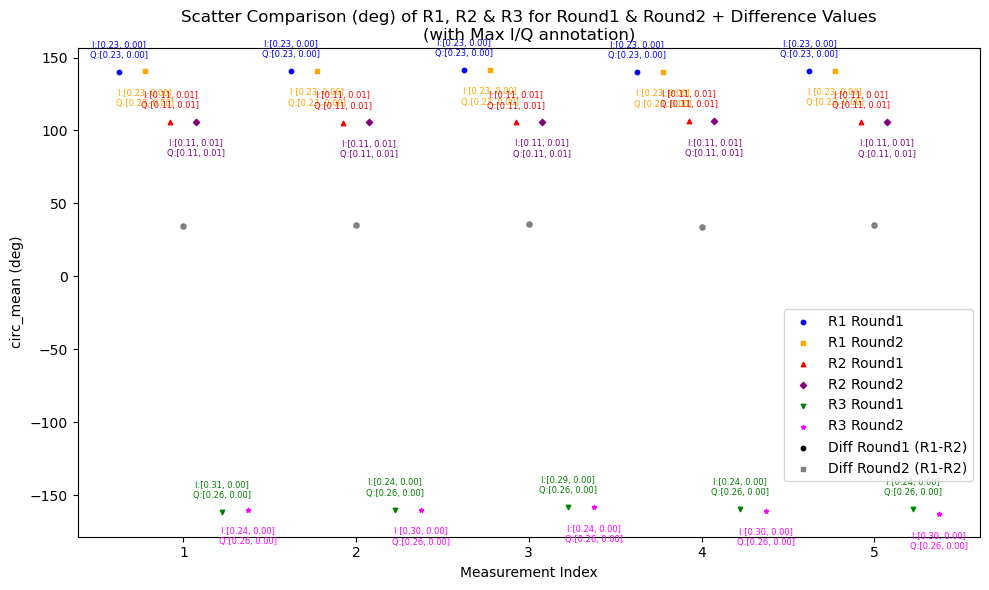

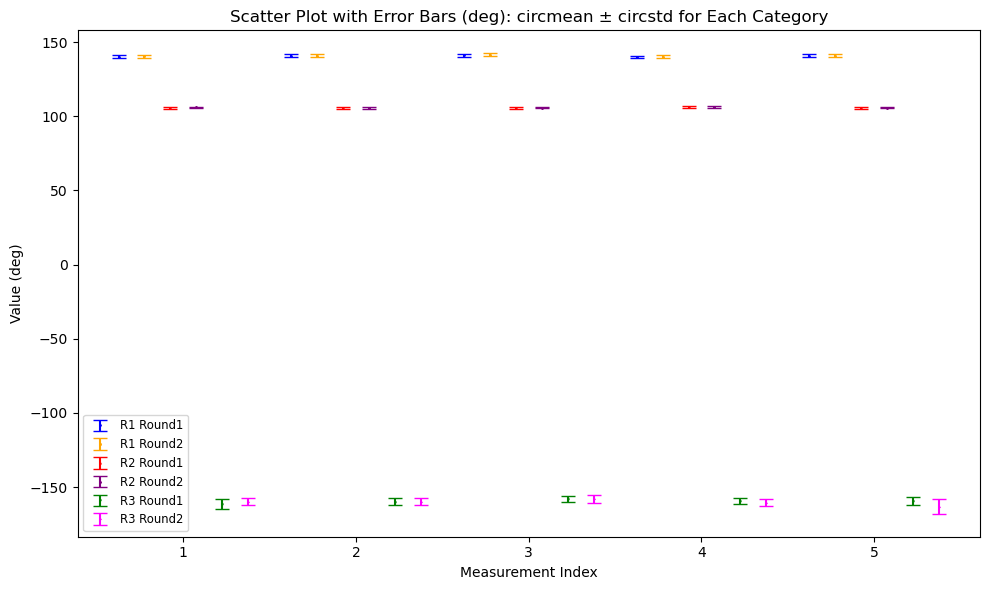

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import tools
from tqdm import tqdm

def parse_timestamp(filename, round_tag):
    if round_tag not in filename:
        return None
    parts = filename.split(round_tag + "_")
    if len(parts) < 2:
        return None
    timestamp_str = parts[1].replace(".npy", "")
    if not timestamp_str:
        return None
    return timestamp_str

def compute_circ_stats(iq_samples):
    phase_ch0, _ = tools.get_phases_and_apply_bandpass(iq_samples[0, :], deg=True)
    phase_ch1, _ = tools.get_phases_and_apply_bandpass(iq_samples[1, :], deg=True)
    phase_diff = tools.to_min_pi_plus_pi(phase_ch0 - phase_ch1, deg=True)
    circ_mean_val = tools.circmean(phase_diff, deg=True)
    circ_std_val = tools.circstd(phase_diff, deg=True)
    return circ_mean_val, circ_std_val

def get_max_IQ(iq_samples):
    max_I = np.max(np.abs(np.real(iq_samples)), axis=1)
    max_Q = np.max(np.abs(np.imag(iq_samples)), axis=1)
    return max_I, max_Q

def get_sorted_stats(folder_path, round_tag):
    results = []
    files = os.listdir(folder_path)
    for filename in tqdm(files, desc=f"Processing {round_tag} files in {os.path.basename(folder_path)}"):
        if filename.endswith(".npy") and round_tag in filename:
            full_path = os.path.join(folder_path, filename)
            timestamp_str = parse_timestamp(filename, round_tag)
            if not timestamp_str:
                continue
            try:
                iq_samples = np.load(full_path)
                circ_mean_val, circ_std_val = compute_circ_stats(iq_samples)
                max_I, max_Q = get_max_IQ(iq_samples)
                results.append((timestamp_str, circ_mean_val, circ_std_val, max_I, max_Q))
            except Exception as e:
                print(f"处理文件 {filename} 出错: {e}")
    results.sort(key=lambda x: x[0])
    return results

def main():
    current_dir = os.getcwd()
    r1_dir = os.path.join(current_dir, "R1")
    r2_dir = os.path.join(current_dir, "R2")
    r3_dir = os.path.join(current_dir, "R3")  # 新增 R3 文件夹

    r1_round1_stats = get_sorted_stats(r1_dir, "round1")
    r1_round2_stats = get_sorted_stats(r1_dir, "round2")
    r2_round1_stats = get_sorted_stats(r2_dir, "round1")
    r2_round2_stats = get_sorted_stats(r2_dir, "round2")
    r3_round1_stats = get_sorted_stats(r3_dir, "round1")  # R3 round1
    r3_round2_stats = get_sorted_stats(r3_dir, "round2")  # R3 round2

    min_len = min(len(r1_round1_stats), len(r1_round2_stats),
                  len(r2_round1_stats), len(r2_round2_stats),
                  len(r3_round1_stats), len(r3_round2_stats))
    if min_len == 0:
        print("无法绘制：至少一组数据为空或无法匹配。")
        return

    # 提取各类别的 circmean
    r1_round1_vals = [r1_round1_stats[i][1] for i in range(min_len)]
    r1_round2_vals = [r1_round2_stats[i][1] for i in range(min_len)]
    r2_round1_vals = [r2_round1_stats[i][1] for i in range(min_len)]
    r2_round2_vals = [r2_round2_stats[i][1] for i in range(min_len)]
    r3_round1_vals = [r3_round1_stats[i][1] for i in range(min_len)]
    r3_round2_vals = [r3_round2_stats[i][1] for i in range(min_len)]

    # 提取各类别的 max_I 与 max_Q 用于标注
    r1_round1_maxI = [r1_round1_stats[i][3] for i in range(min_len)]
    r1_round1_maxQ = [r1_round1_stats[i][4] for i in range(min_len)]
    r1_round2_maxI = [r1_round2_stats[i][3] for i in range(min_len)]
    r1_round2_maxQ = [r1_round2_stats[i][4] for i in range(min_len)]
    r2_round1_maxI = [r2_round1_stats[i][3] for i in range(min_len)]
    r2_round1_maxQ = [r2_round1_stats[i][4] for i in range(min_len)]
    r2_round2_maxI = [r2_round2_stats[i][3] for i in range(min_len)]
    r2_round2_maxQ = [r2_round2_stats[i][4] for i in range(min_len)]
    r3_round1_maxI = [r3_round1_stats[i][3] for i in range(min_len)]
    r3_round1_maxQ = [r3_round1_stats[i][4] for i in range(min_len)]
    r3_round2_maxI = [r3_round2_stats[i][3] for i in range(min_len)]
    r3_round2_maxQ = [r3_round2_stats[i][4] for i in range(min_len)]

    x = np.arange(1, min_len + 1)
    offset = 0.15
    # 为每组数据定义不同的 x 轴偏移位置（每个测量点分布 6 个位置）
    x_r1_r1 = x - 2.5 * offset
    x_r1_r2 = x - 1.5 * offset
    x_r2_r1 = x - 0.5 * offset
    x_r2_r2 = x + 0.5 * offset
    x_r3_r1 = x + 1.5 * offset
    x_r3_r2 = x + 2.5 * offset

    fig, ax = plt.subplots(figsize=(10, 6))
    # 绘制散点图：circmean (deg)
    ax.scatter(x_r1_r1, r1_round1_vals, marker='o', s=10, color='blue', label='R1 Round1')
    ax.scatter(x_r1_r2, r1_round2_vals, marker='s', s=10, color='orange', label='R1 Round2')
    ax.scatter(x_r2_r1, r2_round1_vals, marker='^', s=10, color='red', label='R2 Round1')
    ax.scatter(x_r2_r2, r2_round2_vals, marker='D', s=10, color='purple', label='R2 Round2')
    ax.scatter(x_r3_r1, r3_round1_vals, marker='v', s=10, color='green', label='R3 Round1')
    ax.scatter(x_r3_r2, r3_round2_vals, marker='*', s=10, color='magenta', label='R3 Round2')

    # 差值散点（保持原有 R1 与 R2 的差值）
    diff_round1 = [r1_round1_vals[i] - r2_round1_vals[i] for i in range(min_len)]
    diff_round2 = [r1_round2_vals[i] - r2_round2_vals[i] for i in range(min_len)]
    ax.scatter(x, diff_round1, marker='o', color='black', s=10, label='Diff Round1 (R1-R2)')
    ax.scatter(x, diff_round2, marker='s', color='gray', s=10, label='Diff Round2 (R1-R2)')

    # 为每个数据点标注 max_I 与 max_Q
    for i in range(min_len):
        # -- R1 Round1 上方 --
        ax.annotate(
            f"I:[{r1_round1_maxI[i][0]:.2f}, {r1_round1_maxI[i][1]:.2f}]\n"
            f"Q:[{r1_round1_maxQ[i][0]:.2f}, {r1_round1_maxQ[i][1]:.2f}]",
            (x_r1_r1[i], r1_round1_vals[i]), textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=6, color='blue'
        )
        # -- R1 Round2 下方 --
        ax.annotate(
            f"I:[{r1_round2_maxI[i][0]:.2f}, {r1_round2_maxI[i][1]:.2f}]\n"
            f"Q:[{r1_round2_maxQ[i][0]:.2f}, {r1_round2_maxQ[i][1]:.2f}]",
            (x_r1_r2[i], r1_round2_vals[i]), textcoords="offset points", xytext=(0, -25),
            ha='center', fontsize=6, color='orange'
        )
        # -- R2 Round1 上方 --
        ax.annotate(
            f"I:[{r2_round1_maxI[i][0]:.2f}, {r2_round1_maxI[i][1]:.2f}]\n"
            f"Q:[{r2_round1_maxQ[i][0]:.2f}, {r2_round1_maxQ[i][1]:.2f}]",
            (x_r2_r1[i], r2_round1_vals[i]), textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=6, color='red'
        )
        # -- R2 Round2 下方 --
        ax.annotate(
            f"I:[{r2_round2_maxI[i][0]:.2f}, {r2_round2_maxI[i][1]:.2f}]\n"
            f"Q:[{r2_round2_maxQ[i][0]:.2f}, {r2_round2_maxQ[i][1]:.2f}]",
            (x_r2_r2[i], r2_round2_vals[i]), textcoords="offset points", xytext=(0, -25),
            ha='center', fontsize=6, color='purple'
        )
        # -- R3 Round1 上方 --
        ax.annotate(
            f"I:[{r3_round1_maxI[i][0]:.2f}, {r3_round1_maxI[i][1]:.2f}]\n"
            f"Q:[{r3_round1_maxQ[i][0]:.2f}, {r3_round1_maxQ[i][1]:.2f}]",
            (x_r3_r1[i], r3_round1_vals[i]), textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=6, color='green'
        )
        # -- R3 Round2 下方 --
        ax.annotate(
            f"I:[{r3_round2_maxI[i][0]:.2f}, {r3_round2_maxI[i][1]:.2f}]\n"
            f"Q:[{r3_round2_maxQ[i][0]:.2f}, {r3_round2_maxQ[i][1]:.2f}]",
            (x_r3_r2[i], r3_round2_vals[i]), textcoords="offset points", xytext=(0, -25),
            ha='center', fontsize=6, color='magenta'
        )

    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.set_xlabel('Measurement Index')
    ax.set_ylabel('circ_mean (deg)')
    ax.set_title('Scatter Comparison (deg) of R1, R2 & R3 for Round1 & Round2 + Difference Values\n(with Max I/Q annotation)')
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0.1))
    plt.tight_layout()
    plt.show()

    # 第二部分：误差棒散点图
    r1_r1_means = r1_round1_vals
    r1_r1_stds  = [r1_round1_stats[i][2] for i in range(min_len)]
    r1_r2_means = r1_round2_vals
    r1_r2_stds  = [r1_round2_stats[i][2] for i in range(min_len)]
    r2_r1_means = r2_round1_vals
    r2_r1_stds  = [r2_round1_stats[i][2] for i in range(min_len)]
    r2_r2_means = r2_round2_vals
    r2_r2_stds  = [r2_round2_stats[i][2] for i in range(min_len)]
    r3_r1_means = r3_round1_vals
    r3_r1_stds  = [r3_round1_stats[i][2] for i in range(min_len)]
    r3_r2_means = r3_round2_vals
    r3_r2_stds  = [r3_round2_stats[i][2] for i in range(min_len)]

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.errorbar(x_r1_r1, r1_r1_means, yerr=r1_r1_stds, fmt='o', ms=1, color='blue', capsize=5, label='R1 Round1')
    ax2.errorbar(x_r1_r2, r1_r2_means, yerr=r1_r2_stds, fmt='s', ms=1, color='orange', capsize=5, label='R1 Round2')
    ax2.errorbar(x_r2_r1, r2_r1_means, yerr=r2_r1_stds, fmt='^', ms=1, color='red', capsize=5, label='R2 Round1')
    ax2.errorbar(x_r2_r2, r2_r2_means, yerr=r2_r2_stds, fmt='D', ms=1, color='purple', capsize=5, label='R2 Round2')
    ax2.errorbar(x_r3_r1, r3_r1_means, yerr=r3_r1_stds, fmt='v', ms=1, color='green', capsize=5, label='R3 Round1')
    ax2.errorbar(x_r3_r2, r3_r2_means, yerr=r3_r2_stds, fmt='*', ms=1, color='magenta', capsize=5, label='R3 Round2')

    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in x])
    ax2.set_xlabel('Measurement Index')
    ax2.set_ylabel('Value (deg)')
    ax2.set_title('Scatter Plot with Error Bars (deg): circmean ± circstd for Each Category')
    ax2.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [9]:
import numpy as np

def read_npy_file(file_path):
    """
    Read a .npy file and print its content
    :param file_path: Path to the .npy file
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        print("Shape of the array:", data.shape)
        print("Data type of the array:", data.dtype)

        if data.ndim == 0:
            print("The array is 0-dimensional and contains a single object:")
            print(data.item())
        else:
            print("First row:", data[0])
            print("Second row:", data[1])
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if __name__ == "__main__":
    file_path = 'result.npy'  # Change to your .npy file path
    read_npy_file(file_path)

Shape of the array: ()
Data type of the array: object
The array is 0-dimensional and contains a single object:
{'data_offline_A05_pilot_round2_20250329_103140': [(-9.603469e-06-7.5773123e-06j), (-8.545222e-06-8.1308e-06j)], 'data_offline_A05_pilot_round1_20250329_105742': [(-8.2438255e-06-7.838357e-06j), (-8.486049e-06-8.092744e-06j)], 'data_offline_A05_pilot_round1_20250329_105259': [(-7.984432e-06-8.036808e-06j), (-8.59554e-06-8.087473e-06j)], 'data_offline_A05_pilot_round2_20250329_095409': [(-8.6157825e-06-7.773512e-06j), (-8.491554e-06-8.0912e-06j)], 'data_offline_A05_pilot_round1_20250327_132639': [(-8.326689e-06-7.921759e-06j), (-8.561924e-06-8.090586e-06j)], 'data_offline_A05_pilot_round2_20250327_144323': [(-8.1965145e-06-8.250779e-06j), (-8.445797e-06-8.052473e-06j)], 'data_offline_A05_pilot_round2_20250327_130944': [(-7.311364e-06-9.473425e-06j), (-8.552135e-06-8.114354e-06j)], 'data_offline_A05_pilot_round2_20250327_145044': [(-9.118562e-06-7.2821704e-06j), (-8.471894e-06-8

In [8]:
import numpy as np

def process_npy_file(file_path):
    """
    Read a .npy file and calculate the mean of each row
    :param file_path: Path to the .npy file
    """
    try:
        data = np.load(file_path)
        if data.ndim != 2:
            print(f"Invalid data shape: {data.shape}. Expected a 2D array.")
            return

        row_means = np.mean(data, axis=1)
        for i, mean in enumerate(row_means):
            print(f"Mean of row {i}: {mean}")

    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if __name__ == "__main__":
    file_path = 'phase_data.npy'  # Change to your .npy file path
    process_npy_file(file_path)

Error reading file phase_data.npy: Object arrays cannot be loaded when allow_pickle=False


In [18]:
import numpy as np

def read_npy_file(file_path):
    """
    Read a .npy file and print its shape
    :param file_path: Path to the .npy file
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        print("Shape of the array:", data.shape)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if __name__ == "__main__":
    file_path = 'phase_data.npy'  # Change to your .npy file path
    read_npy_file(file_path)

Shape of the array: (33, 507)


In [25]:
import os
import re
import math

def process_device_file(file_path):
    """
    处理单个设备文件：
      - 按照分隔符 '----------------------------------------' 拆分数据段；
      - 只提取包含 "round1" 的数据段；
      - 从数据段中提取时间戳（格式 round1_YYYYMMDD_HHMMSS）和 “CircMean phase diff” 数值；
      - 将 phase 数值转换为复数：实部为 cos(phase)，虚部为 sin(phase)；
      - 按时间戳排序后返回一个列表，每个元素为一个复数。
    """
    segments_data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # 按照分隔符拆分数据段，并去除多余空白字符
    segments = [seg.strip() for seg in content.split('----------------------------------------') if seg.strip()]

    for seg in segments:
        # 只处理包含 "Processing file:" 的数据段
        if 'Processing file:' not in seg:
            continue

        # 提取 "Processing file:" 后面的文件名
        m_file = re.search(r'Processing file:\s*(\S+)', seg)
        if not m_file:
            continue
        filename = m_file.group(1)

        # 只处理文件名中包含 "round1" 的数据段
        if "round1" not in filename:
            continue

        # 从文件名中提取时间戳，格式假设为 round1_YYYYMMDD_HHMMSS
        m_ts = re.search(r'round1_(\d{8}_\d{6})', filename)
        if not m_ts:
            continue
        timestamp = m_ts.group(1)

        # 提取 “CircMean phase diff” 数值（单位为 rad）
        m_phase = re.search(r'CircMean phase diff:\s*([-+]?[0-9]*\.?[0-9]+)', seg)
        if not m_phase:
            continue
        try:
            phase_val = float(m_phase.group(1))
        except ValueError:
            continue

        # 计算复数：实部为 cos(phase)，虚部为 sin(phase)
        comp_value = complex(math.cos(phase_val), math.sin(phase_val))
        segments_data.append((timestamp, comp_value))

    # 根据时间戳排序（YYYYMMDD_HHMMSS 格式，直接字符串排序即可）
    segments_data.sort(key=lambda x: x[0])

    # 返回排序后的复数值列表
    return [comp for ts, comp in segments_data]

def main():
    data_folder = "Data"
    if not os.path.exists(data_folder):
        print(f"错误：目录 {data_folder} 不存在。")
        return

    # 遍历 Data 文件夹下所有 _result.txt 文件
    device_files = sorted([f for f in os.listdir(data_folder) if f.endswith("_result.txt")])

    for file_name in device_files:
        file_path = os.path.join(data_folder, file_name)
        measurements = process_device_file(file_path)
        # 提取设备名（假设文件名格式为 {设备名}_result.txt）
        device = file_name.split('_')[0]
        print(f"设备 {device} 的数据长度: {len(measurements)}")

if __name__ == "__main__":
    main()


设备 A05 的数据长度: 505
设备 A06 的数据长度: 505
设备 A07 的数据长度: 505
设备 A08 的数据长度: 505
设备 A09 的数据长度: 505
设备 B07 的数据长度: 505
设备 B08 的数据长度: 505
设备 B10 的数据长度: 505
设备 C05 的数据长度: 505
设备 C06 的数据长度: 505
设备 C07 的数据长度: 505
设备 C08 的数据长度: 505
设备 C09 的数据长度: 505
设备 C10 的数据长度: 505
设备 D05 的数据长度: 505
设备 D07 的数据长度: 505
设备 D08 的数据长度: 505
设备 D10 的数据长度: 505
设备 E05 的数据长度: 505
设备 E06 的数据长度: 505
设备 E07 的数据长度: 505
设备 E08 的数据长度: 505
设备 E09 的数据长度: 505
设备 E10 的数据长度: 505
设备 F05 的数据长度: 505
设备 F07 的数据长度: 505
设备 F08 的数据长度: 505
设备 F10 的数据长度: 505
设备 G05 的数据长度: 505
设备 G06 的数据长度: 505
设备 G07 的数据长度: 505
设备 G08 的数据长度: 505
设备 G09 的数据长度: 505
